Classifies injuries as fatal (2), non-fatal injury (1), or no injury (0)

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../../data/person_data.csv')
df.head()

,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1.0,1,NaN,1,F,51.0,11,2.0,2.0,1.0,915642
1,1.0,1,NaN,NN,N,NaN,NN,NaN,NaN,NaN,915794
2,2.0,22,NaN,1,M,11.0,11,2.0,13.0,NaN,915794
3,1.0,1,NaN,1,M,82.0,11,1.0,NaN,1.0,915805
4,2.0,1,NaN,1,F,70.0,11,2.0,2.0,1.0,915805


In [3]:
df["P_SEX"].value_counts()

P_SEX
M    2669396
F    2129126
N      12436
Name: count, dtype: int64

In [4]:
df.columns

Index(['V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV',
       'P_SAFE', 'P_USER', 'C_CASE'],
      dtype='object')

In [5]:
df.shape

(5062389, 11)

In [6]:
df.isna().sum()

V_ID          219
V_TYPE      47799
V_YEAR     257954
P_ID        12527
P_SEX      251431
P_AGE      359044
P_PSN      148386
P_ISEV     353327
P_SAFE    1093317
P_USER     216817
C_CASE          0
dtype: int64

In [7]:
# drop ID columns and rows with missing target
df = df.drop(columns=["C_CASE", "P_ID", "V_ID"], errors="ignore")
df = df.dropna(subset=["P_ISEV"])

# map injury severity to 0, 1, 2
df["P_ISEV"] = df["P_ISEV"].map({1: 0, 2: 1, 3: 2})

# # map sex to numerical values
# df["P_ISEV"] = df["P_ISEV"].map({"F": 0, "M": 1, "N": -1})

for col in ['V_TYPE', 'V_YEAR', 'P_SEX', 'P_PSN']:
    df[col] = df[col].astype('category').cat.codes

df.head()

,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,6,-1,0,51.0,0,1,2.0,1.0
2,16,-1,1,11.0,0,1,13.0,NaN
3,6,-1,1,82.0,0,0,NaN,1.0
4,6,-1,0,70.0,0,1,2.0,1.0
5,6,-1,0,32.0,0,1,2.0,1.0


In [8]:
df.columns

Index(['V_TYPE', 'V_YEAR', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER'],
      dtype='object')

In [9]:
df.dtypes

V_TYPE       int8
V_YEAR       int8
P_SEX        int8
P_AGE     float64
P_PSN        int8
P_ISEV      int64
P_SAFE    float64
P_USER    float64
dtype: object

In [10]:
df['P_ISEV'].value_counts()

P_ISEV
1    2636996
0    2037680
2      34386
Name: count, dtype: int64

In [11]:
numeric_features = [
    "V_YEAR", 
    "P_AGE"
]

categorical_features = [
    "V_TYPE",
    "P_SEX",
    "P_PSN",
    "P_ISEV",
    "P_SAFE",
    "P_USER"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [12]:
X = df.drop("P_ISEV", axis=1)
y = df["P_ISEV"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,     
    shuffle=True         
)

### Try default XGBoost classifier

In [13]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
y_pred = model.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57    407538
           1       0.67      0.77      0.71    527342
           2       1.00      0.00      0.00      6933

    accuracy                           0.65    941813
   macro avg       0.77      0.43      0.43    941813
weighted avg       0.65      0.65      0.64    941813



### Use sample_weight to tell the model to give more weight to the minority classes

In [18]:
from sklearn.utils.class_weight import compute_sample_weight

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,     
    shuffle=True         
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test,
    test_size=0.5,      
    random_state=42,     
    shuffle=True         
)

# y_train is array-like of labels (0,1,2...)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    max_depth=6,
    n_estimators=500,
    learning_rate=0.1,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weight, eval_set=[(X_val, y_val)], verbose=50)

c:\Users\jylis\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [21:23:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.07836
[50]	validation_0-mlogloss:0.92653
[100]	validation_0-mlogloss:0.91881
[150]	validation_0-mlogloss:0.91581
[200]	validation_0-mlogloss:0.91389
[250]	validation_0-mlogloss:0.91239
[300]	validation_0-mlogloss:0.91104
[350]	validation_0-mlogloss:0.90970
[400]	validation_0-mlogloss:0.90859
[450]	validation_0-mlogloss:0.90762
[499]	validation_0-mlogloss:0.90656


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [19]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63    203307
           1       0.70      0.45      0.55    264117
           2       0.03      0.56      0.06      3483

    accuracy                           0.55    470907
   macro avg       0.44      0.57      0.41    470907
weighted avg       0.64      0.55      0.58    470907



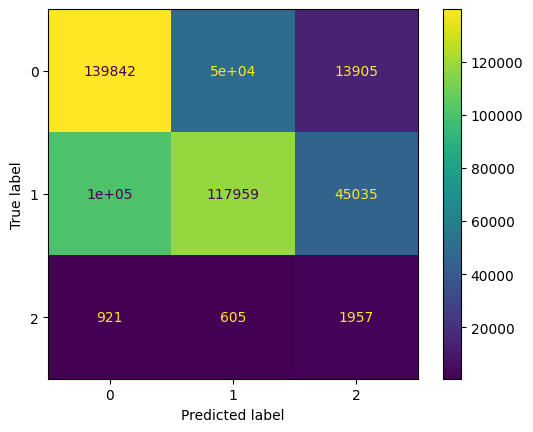

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Random undersampling of non-fatal injuries (default model)

In [25]:
df["P_ISEV"].value_counts()

P_ISEV
1    2636996
0    2037680
2      34386
Name: count, dtype: int64

In [27]:
num_fatality = df[df["P_ISEV"] == 2].shape[0]
num_fatal_injury = df[df["P_ISEV"] == 2].shape[0]
df_undersampled_0 = df[df["P_ISEV"] == 0].sample(n=num_fatality * 2, random_state=42)
df_undersampled_1 = df[df["P_ISEV"] == 1].sample(n=num_fatality * 2, random_state=42)
df_balanced = pd.concat([df[df["P_ISEV"] == 2], df_undersampled_0, df_undersampled_1])

In [31]:
X = df_balanced.drop("P_ISEV", axis=1)
y = df_balanced["P_ISEV"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,     
    shuffle=True         
)

model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63     13625
           1       0.57      0.50      0.53     13942
           2       0.63      0.43      0.51      6819

    accuracy                           0.57     34386
   macro avg       0.59      0.55      0.56     34386
weighted avg       0.58      0.57      0.57     34386



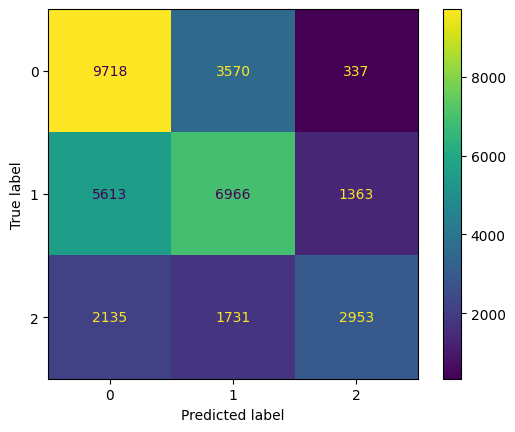

In [33]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Increase Recall for Rare Class (Fatalities) Using scale_pos_weight Equivalent

In [34]:
X = df.drop("P_ISEV", axis=1)
y = df["P_ISEV"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,     
    shuffle=True         
)

weights = np.ones(len(y_train))

# Boost minority class (fatalities)
weights[y_train == 2] = 10    # tune this number (5–100)

model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
)
model.fit(X_train, y_train, sample_weight=weights)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57    407538
           1       0.67      0.75      0.71    527342
           2       0.11      0.15      0.12      6933

    accuracy                           0.65    941813
   macro avg       0.47      0.47      0.47    941813
weighted avg       0.65      0.65      0.64    941813



### Lower the Classification Threshold for Class 2

In [35]:
probs = model.predict_proba(X_test)

adjusted = probs.copy()
adjusted[:,2] *= 2.0     # make class 2 more likely

y_pred = adjusted.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57    407538
           1       0.66      0.73      0.69    527342
           2       0.07      0.26      0.11      6933

    accuracy                           0.63    941813
   macro avg       0.45      0.50      0.46    941813
weighted avg       0.64      0.63      0.64    941813

